<a href="https://colab.research.google.com/github/skywalker0803r/Chemistry-2/blob/master/Chemistry_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import warnings;warnings.simplefilter('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# load raw data

In [3]:
df = pd.read_excel('/content/drive/My Drive/台化二部/data/操作與品管數據(20200102提供).xlsx')
df.head()

,Unnamed: 0,R141入口,Unnamed: 2,Unnamed: 3,Unnamed: 4,R141反應溫度,Unnamed: 6,Unnamed: 7,Unnamed: 8,R141出口,Unnamed: 10,品管數據,Unnamed: 12,Unnamed: 13
0,NaN,新鮮苯流量(M3/h),DIPB流量(M3/h),溫度(℃),壓力(KGf/cm2 G),第一床(℃),第二床(℃),第三床(℃),第四床(℃),溫度(℃),壓力(KGf/cm2 G),ppm,%,%
1,DATE,PHL-DCS-FIC1147_PV,PHL-DCS-FIC1149A_PV,PHL-DCS-TIC1163_PV,PHL-DCS-PI1162_PV,PHL-DCS-TI1166_PV,PHL-DCS-TI1167_PV,PHL-DCS-TI1168_PV,PHL-DCS-TI1169_PV,PHL-DCS-TI1170_PV,PHL-DCS-PIC1166_PV,T121 EB含量,DIPB轉化率(檢測),DIPB轉化率(計算)
2,2013-08-20 10:10:00,31.212,24.9928,169.894,[-11059] No Good Data For Calculation,167.057,166.569,166.279,165.041,[-11059] No Good Data For Calculation,12.297,NaN,NaN,58.7768
3,2013-08-20 10:20:00,31.2236,25.0668,169.753,[-11059] No Good Data For Calculation,167.051,166.576,166.26,164.97,[-11059] No Good Data For Calculation,12.2914,NaN,NaN,58.8524
4,2013-08-20 10:30:00,31.5726,25.163,169.526,[-11059] No Good Data For Calculation,167.042,166.584,166.235,164.877,[-11059] No Good Data For Calculation,12.3175,NaN,NaN,59.1137


# table data

In [4]:
cols = ['Date','R141入口_新鮮苯流量','R141入口_DIPB流量','R141入口_溫度','R141入口_壓力',
        'R141反應溫度_第一床','R141反應溫度_第二床','R141反應溫度_第三床','R141反應溫度_第四床',
        'R141出口_溫度','R141出口_壓力','T121_EB含量','DIPB轉化率(檢測)','DIPB轉化率(計算)']
values = df.iloc[2:,:]
values
new_df = pd.DataFrame(values.values,columns=cols)
new_df.head()

,Date,R141入口_新鮮苯流量,R141入口_DIPB流量,R141入口_溫度,R141入口_壓力,R141反應溫度_第一床,R141反應溫度_第二床,R141反應溫度_第三床,R141反應溫度_第四床,R141出口_溫度,R141出口_壓力,T121_EB含量,DIPB轉化率(檢測),DIPB轉化率(計算)
0,2013-08-20 10:10:00,31.212,24.9928,169.894,[-11059] No Good Data For Calculation,167.057,166.569,166.279,165.041,[-11059] No Good Data For Calculation,12.297,NaN,NaN,58.7768
1,2013-08-20 10:20:00,31.2236,25.0668,169.753,[-11059] No Good Data For Calculation,167.051,166.576,166.26,164.97,[-11059] No Good Data For Calculation,12.2914,NaN,NaN,58.8524
2,2013-08-20 10:30:00,31.5726,25.163,169.526,[-11059] No Good Data For Calculation,167.042,166.584,166.235,164.877,[-11059] No Good Data For Calculation,12.3175,NaN,NaN,59.1137
3,2013-08-20 10:40:00,31.8862,25.1367,169.317,[-11059] No Good Data For Calculation,167.034,166.592,166.21,164.784,[-11059] No Good Data For Calculation,12.3179,NaN,NaN,58.8904
4,2013-08-20 10:50:00,31.8554,25.2207,169.665,[-11059] No Good Data For Calculation,167.026,166.6,166.186,164.691,[-11059] No Good Data For Calculation,12.3155,NaN,NaN,58.7622


# col transform

In [0]:
new_df = new_df.replace('[-11059] No Good Data For Calculation',np.nan)

In [6]:
for i in new_df.columns.tolist()[1:]:
  new_df[i] = pd.to_numeric(new_df[i])
new_df.dtypes

Date             datetime64[ns]
R141入口_新鮮苯流量            float64
R141入口_DIPB流量           float64
R141入口_溫度               float64
R141入口_壓力               float64
R141反應溫度_第一床            float64
R141反應溫度_第二床            float64
R141反應溫度_第三床            float64
R141反應溫度_第四床            float64
R141出口_溫度               float64
R141出口_壓力               float64
T121_EB含量               float64
DIPB轉化率(檢測)             float64
DIPB轉化率(計算)             float64
dtype: object

# miss value check

In [7]:
mt = pd.DataFrame(new_df.isnull().sum(),columns=['total'])
mt['%'] = (mt['total']/len(new_df))*100
mt

,total,%
Date,0,0.000000
R141入口_新鮮苯流量,71,0.085514
R141入口_DIPB流量,71,0.085514
R141入口_溫度,71,0.085514
R141入口_壓力,47276,56.940513
R141反應溫度_第一床,71,0.085514
R141反應溫度_第二床,71,0.085514
R141反應溫度_第三床,71,0.085514
R141反應溫度_第四床,71,0.085514
R141出口_溫度,47275,56.939309


# describe

In [8]:
new_df.describe().apply(lambda x:round(x,2))

,R141入口_新鮮苯流量,R141入口_DIPB流量,R141入口_溫度,R141入口_壓力,R141反應溫度_第一床,R141反應溫度_第二床,R141反應溫度_第三床,R141反應溫度_第四床,R141出口_溫度,R141出口_壓力,T121_EB含量,DIPB轉化率(檢測),DIPB轉化率(計算)
count,82956.00,82956.00,82956.00,35751.00,82956.00,82956.00,82956.00,82956.00,35752.00,82956.00,1558.00,488.00,76553.00
mean,33.27,22.74,165.90,14.41,157.73,157.85,157.64,156.10,164.57,11.39,97.09,60.08,58.87
std,11.02,6.74,16.82,0.13,36.05,36.14,36.09,36.59,6.08,3.14,25.09,14.73,4.01
min,0.03,0.00,110.04,7.41,17.49,17.30,17.15,0.00,54.79,0.00,8.00,-44.02,-0.63
25%,31.12,24.17,168.80,14.38,165.68,165.38,165.01,163.47,164.39,12.30,83.00,59.10,57.34
50%,35.17,24.80,170.48,14.42,167.54,167.69,167.44,166.49,165.37,12.30,94.00,64.22,58.42
75%,40.99,25.50,173.02,14.44,170.29,170.67,170.39,169.37,166.37,12.30,105.00,67.89,59.74
max,52.73,29.72,184.35,15.10,182.30,177.28,187.30,176.02,173.64,12.73,283.00,72.99,290.24


# EDA

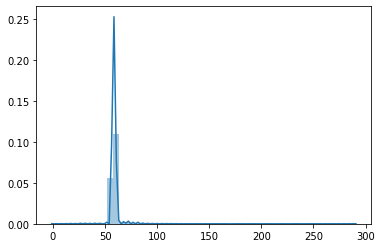

In [9]:
import seaborn as sns

sns.distplot(new_df['DIPB轉化率(計算)'].dropna().values)

R141入口_新鮮苯流量


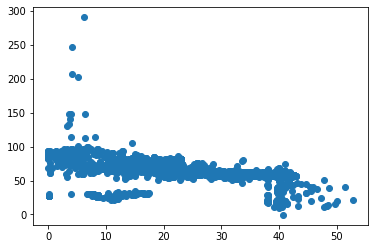

R141入口_DIPB流量


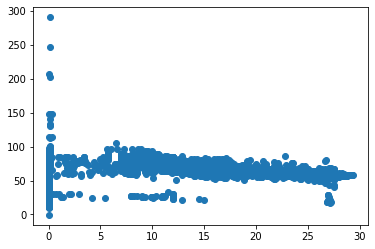

R141入口_溫度


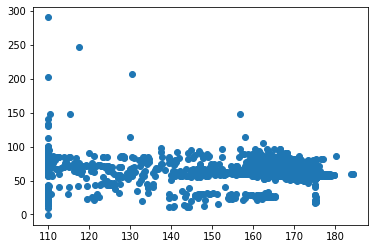

R141入口_壓力


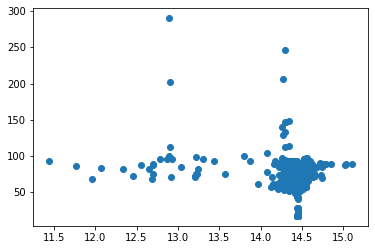

R141反應溫度_第一床


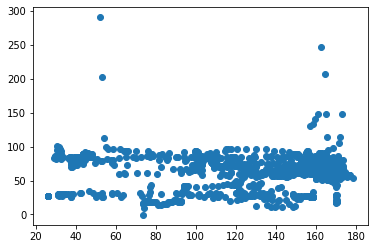

R141反應溫度_第二床


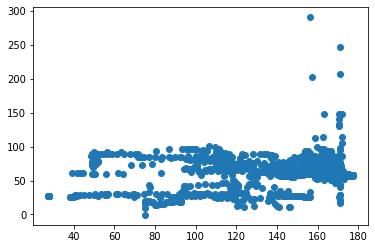

R141反應溫度_第三床


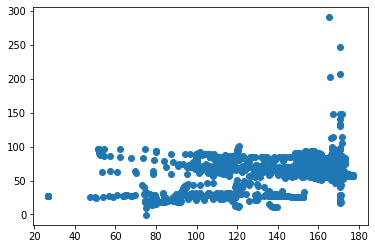

R141反應溫度_第四床


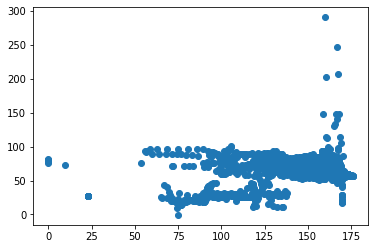

R141出口_溫度


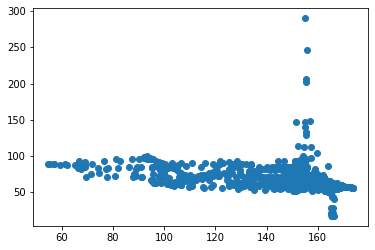

R141出口_壓力


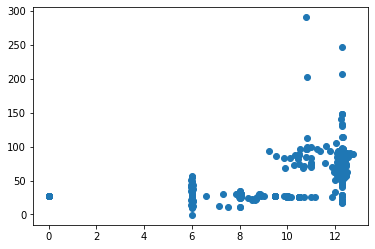

T121_EB含量


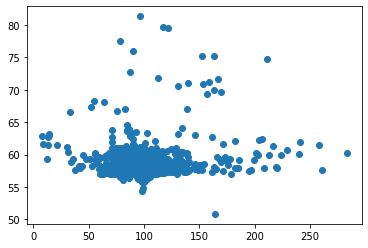

DIPB轉化率(檢測)


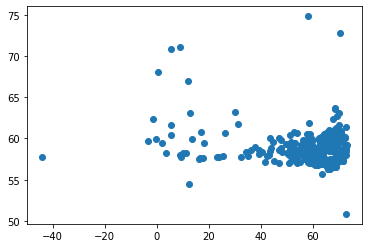

DIPB轉化率(計算)


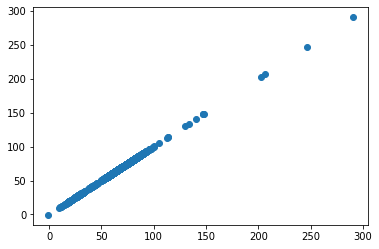

In [10]:
import matplotlib.pyplot as plt

y_name = 'DIPB轉化率(計算)'
for i in new_df.columns.tolist()[1:]:
  print(i)
  plt.scatter(new_df[i],new_df[y_name])
  plt.show()

In [11]:
new_df.corr().style.background_gradient()

,R141入口_新鮮苯流量,R141入口_DIPB流量,R141入口_溫度,R141入口_壓力,R141反應溫度_第一床,R141反應溫度_第二床,R141反應溫度_第三床,R141反應溫度_第四床,R141出口_溫度,R141出口_壓力,T121_EB含量,DIPB轉化率(檢測),DIPB轉化率(計算)
R141入口_新鮮苯流量,1,0.884923,0.89913,0.304174,0.849823,0.847297,0.841579,0.862173,0.73121,0.844226,-0.23428,-0.0443793,-0.504345
R141入口_DIPB流量,0.884923,1,0.934985,0.365651,0.877757,0.868036,0.859819,0.882931,0.683053,0.880731,-0.0201724,0.121691,-0.396776
R141入口_溫度,0.89913,0.934985,1,0.350941,0.94357,0.932389,0.923426,0.939352,0.604921,0.947079,0.0629258,-0.156108,-0.205548
R141入口_壓力,0.304174,0.365651,0.350941,1,0.309391,0.262835,0.297407,0.274725,0.325315,0.962897,-0.261149,-0.321703,-0.151401
R141反應溫度_第一床,0.849823,0.877757,0.94357,0.309391,1,0.991727,0.984078,0.978121,0.648831,0.940253,-0.0662891,-0.128274,-0.117629
R141反應溫度_第二床,0.847297,0.868036,0.932389,0.262835,0.991727,1,0.994928,0.986913,0.689236,0.943591,-0.082717,-0.13459,-0.0606133
R141反應溫度_第三床,0.841579,0.859819,0.923426,0.297407,0.984078,0.994928,1,0.991156,0.789451,0.941671,-0.0921779,-0.116291,-0.0383855
R141反應溫度_第四床,0.862173,0.882931,0.939352,0.274725,0.978121,0.986913,0.991156,1,0.916927,0.959771,-0.100037,-0.096656,-0.0874654
R141出口_溫度,0.73121,0.683053,0.604921,0.325315,0.648831,0.689236,0.789451,0.916927,1,0.350758,0.291141,0.053617,-0.496486
R141出口_壓力,0.844226,0.880731,0.947079,0.962897,0.940253,0.943591,0.941671,0.959771,0.350758,1,-0.0576365,-0.0165576,0.401551


# features engineering

In [0]:
pass

# feature select

In [13]:
features = ['R141入口_新鮮苯流量','R141入口_DIPB流量','R141入口_溫度','R141入口_壓力','R141出口_溫度','R141出口_壓力']
y_name = 'DIPB轉化率(計算)'
new_df = new_df[features+[y_name]].dropna(subset=[y_name])
X = new_df[features]
y = new_df[y_name]
print(X.shape,y.shape)

(76553, 6) (76553,)


# split

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# model

In [0]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor

model = Pipeline(steps=[
                        ('scaler',StandardScaler()),
                        ('reg',XGBRegressor(objective='reg:squarederror')),
                        ])

# train and predict

In [0]:
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

# metric

In [0]:
y_pred = pd.Series(y_pred,index=y_test.index,name='y_pred')

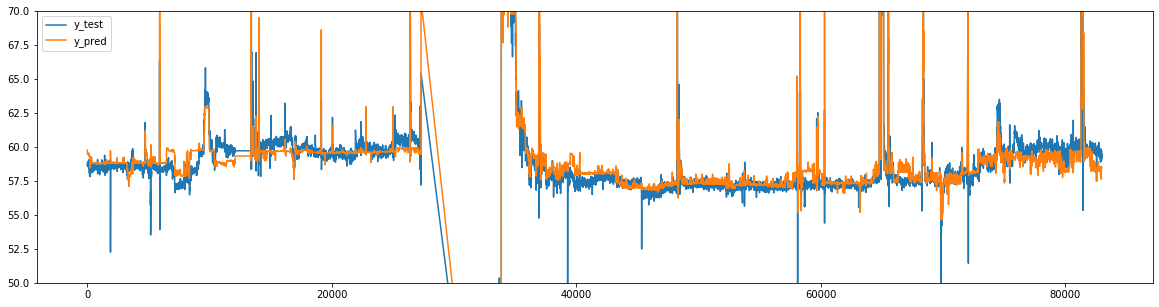

In [18]:
fig = plt.figure(figsize=(20,5))
plt.plot(y_test.sort_index(),label='y_test')
plt.plot(y_pred.sort_index(),label='y_pred')
plt.ylim(50,70)
plt.legend()

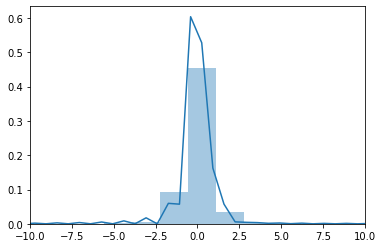

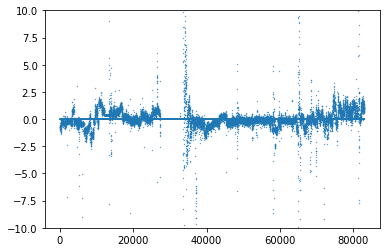

In [19]:
residual = y_test - y_pred
sns.distplot(residual)
plt.xlim(-10,10)
plt.show()

plt.scatter(residual.index,residual,s=0.1)
plt.plot(residual.index,[0]*len(residual))
plt.ylim(-10,10)
plt.show()

In [0]:
from sklearn.metrics import r2_score
def mape(a, b): 
  mask = a != 0
  return (np.fabs(a - b)/a)[mask].mean()

In [21]:
r2_score(y_test,y_pred)

0.8490106198472037

In [22]:
mape(y_test,y_pred)

0.011248060362437745